### Loading Dataset

In [1]:
#importing packages

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Loading the datasets
events = pd.read_csv('events.csv')
item_properties_part1 = pd.read_csv('item_properties_part1.csv')
item_properties_part2 = pd.read_csv('item_properties_part2.csv')
category_tree = pd.read_csv('category_tree.csv')

#Combining the item properties into a single DataFrame
item_properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)

#Displaying the first few rows of each dataframe
print(events.head())
print('\n', item_properties.head())
print('\n', category_tree.head())


       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

        timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

    categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0


### Data Preperation

In [3]:
#Converting timestamps to datetime for easier manipulation and analysis
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')

In [4]:
#Checking for missing values in important columns
print(events.isnull().sum())

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


The missing values in the 'transactionid' column indicate that those particular events are not transactions. This is normal since not every event in the dataset will be a transaction. Events like 'view' and 'addtocart' will not have a transactionid.

In [5]:
#Counting the number of unique visitors for each stage of the funnel
funnel_counts = events.groupby('event')['visitorid'].nunique()
print(funnel_counts)

event
addtocart        37722
transaction      11719
view           1404179
Name: visitorid, dtype: int64


### Analyzing the funnel

In [6]:
#Defining funnel stages
funnel_stages = ['view', 'addtocart', 'transaction']

#Reindexing to ensure all stages are present
funnel_counts = funnel_counts.reindex(funnel_stages, fill_value=0)
print(funnel_counts)


event
view           1404179
addtocart        37722
transaction      11719
Name: visitorid, dtype: int64


***The conversion rate from one stage to the next is the number of unique users at the next stage divided by the number of unique users at the current stage.***

In [7]:
#Calculating conversion rates
conversion_rate_view_to_cart = funnel_counts['addtocart'] / funnel_counts['view']
conversion_rate_cart_to_transaction = funnel_counts['transaction'] / funnel_counts['addtocart']

print("Conversion Rate from View to Add to Cart:", conversion_rate_view_to_cart * 100, "%")
print("Conversion Rate from Add to Cart to Transaction:", conversion_rate_cart_to_transaction * 100, "%")


Conversion Rate from View to Add to Cart: 2.6864096386571794 %
Conversion Rate from Add to Cart to Transaction: 31.066751497799693 %


***Drop-off rates show the proportion of users who do not proceed to the next stage.***

In [8]:
#Calculating drop-off rates
drop_off_rate_view_to_cart = 1 - conversion_rate_view_to_cart
drop_off_rate_cart_to_transaction = 1 - conversion_rate_cart_to_transaction

print("Drop-Off Rate from View to Add to Cart:", drop_off_rate_view_to_cart)
print("Drop-Off Rate from Add to Cart to Transaction:", drop_off_rate_cart_to_transaction)

Drop-Off Rate from View to Add to Cart: 0.9731359036134282
Drop-Off Rate from Add to Cart to Transaction: 0.6893324850220031


### Visualisation and Analysis 

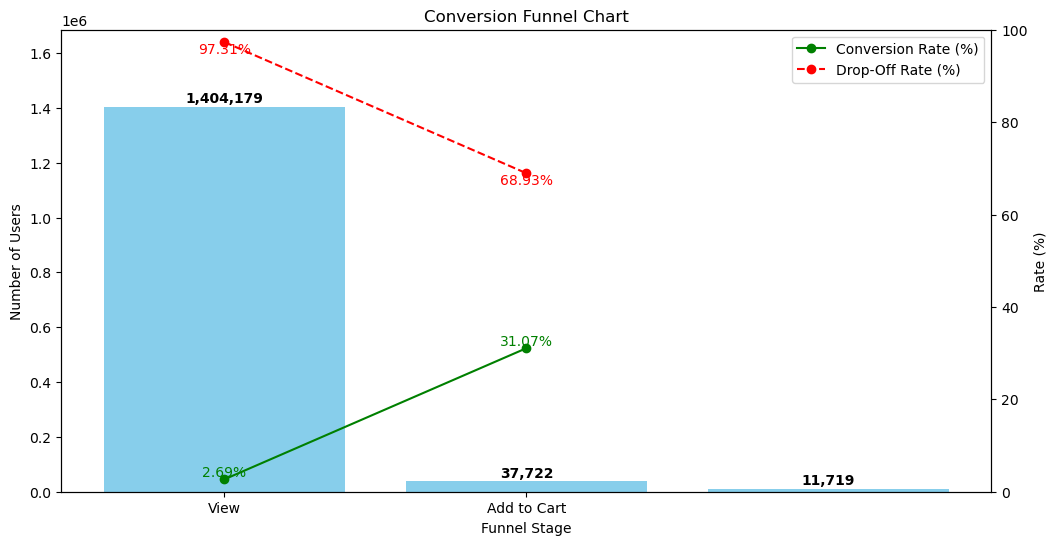

In [10]:
#Defining funnel counts and stages
stages = ['View', 'Add to Cart', 'Transaction']
counts = [funnel_counts['view'], funnel_counts['addtocart'], funnel_counts['transaction']]

#Calculating conversion and drop-off rates
conversion_rates = [0] * (len(counts) - 1)
drop_off_rates = [0] * (len(counts) - 1)

for i in range(1, len(counts)):
    conversion_rates[i-1] = (counts[i] / counts[i-1]) * 100 if counts[i-1] != 0 else 0
    drop_off_rates[i-1] = 100 - conversion_rates[i-1]

#Creating a funnel chart
fig, ax1 = plt.subplots(figsize=(12, 6))

#Plotting the funnel stages
bars = ax1.bar(stages, counts, color='skyblue')

#Adding text annotations for counts
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + max(counts) * 0.01,
             f'{int(height):,}', ha='center', color='black', weight='bold')

#Creating a secondary y-axis for conversion rates
ax2 = ax1.twinx()
ax2.plot(stages[:-1], conversion_rates, color='green', marker='o', linestyle='-', label='Conversion Rate (%)')
ax2.plot(stages[:-1], drop_off_rates, color='red', marker='o', linestyle='--', label='Drop-Off Rate (%)')

#Adding text annotations for rates
for i in range(len(conversion_rates)):
    ax2.text(i, conversion_rates[i], f'{conversion_rates[i]:.2f}%', color='green', ha='center', va='bottom')
    ax2.text(i, drop_off_rates[i], f'{drop_off_rates[i]:.2f}%', color='red', ha='center', va='top')

ax2.set_ylabel('Rate (%)')
ax2.legend(loc='upper right')

#Adding title and labels
ax1.set_title('Conversion Funnel Chart')
ax1.set_xlabel('Funnel Stage')
ax1.set_ylabel('Number of Users')
ax1.set_ylim(0, max(counts) * 1.2)
ax2.set_ylim(0, 100)

plt.show()


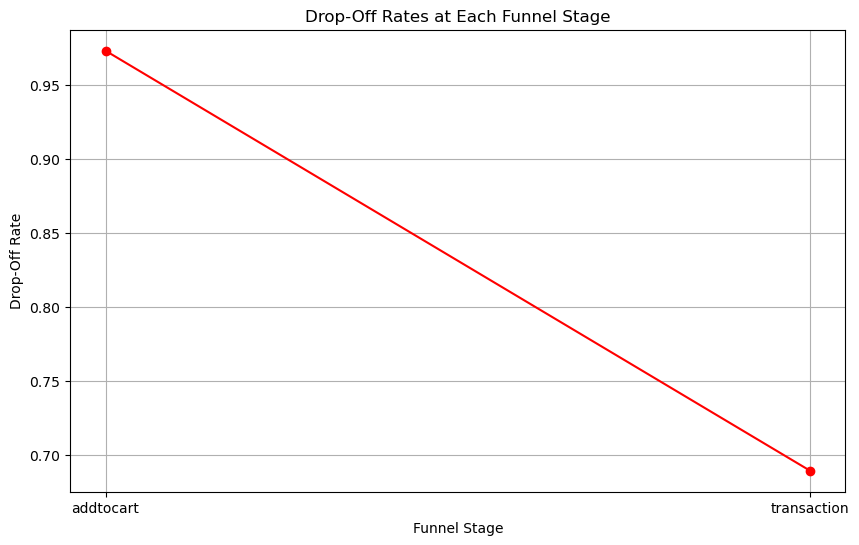

In [11]:
#Preparing data for drop-off rates visualization
drop_off_rates = {
    'stage': ['addtocart', 'transaction'],
    'drop_off_rate': [drop_off_rate_view_to_cart, drop_off_rate_cart_to_transaction]
}

drop_off_df = pd.DataFrame(drop_off_rates)

#Drop-off rates visualization
plt.figure(figsize=(10, 6))
plt.plot(drop_off_df['stage'], drop_off_df['drop_off_rate'], marker='o', linestyle='-', color='red')
plt.title('Drop-Off Rates at Each Funnel Stage')
plt.xlabel('Funnel Stage')
plt.ylabel('Drop-Off Rate')
plt.grid(True)
plt.show()


- **Drop-Off Rate from View to Add to Cart**:
  - The drop-off rate is high (around 0.97), indicating that a significant portion of users who view products do not add them to their cart. This is the first stage in the user journey and typically has the highest drop-off rate.

- **Drop-Off Rate from Add to Cart to Transaction**:
  - The drop-off rate decreases to around 0.69, indicating that fewer users abandon their journey after adding items to the cart compared to the initial view stage. This shows an improvement in user retention as they move closer to making a transaction.

### Insights and Actions

1. **High Drop-Off at Initial Stage**:
   - The very high drop-off rate from `View` to `Add to Cart` suggests that many users are not sufficiently motivated or convinced to add items to their cart. The following actions can be considered based on industry best practices:
     - Improve product page quality with better images, descriptions, and reviews.
     - Offer incentives like discounts or free shipping for adding items to the cart.
     - Simplify navigation and make the add-to-cart button more prominent.
     

2. **Moderate Drop-Off from Cart to Transaction**:
   - While the drop-off rate decreases at this stage, there is still a significant number of users who do not complete the transaction after adding items to their cart. The following actions can be considered to decrease drop-off
     - Simplify the checkout process to reduce friction.
     - Provide multiple payment options and ensure a smooth payment experience.
     - Send reminder emails to users who have items in their cart but have not completed the purchase.


### Hypothetical Improvements

Assuming the following hypothetical improvements in conversion rates:

- Increase the conversion rate from View to Add to Cart by 5%.
- Increase the conversion rate from Add to Cart to Transaction by 10%.

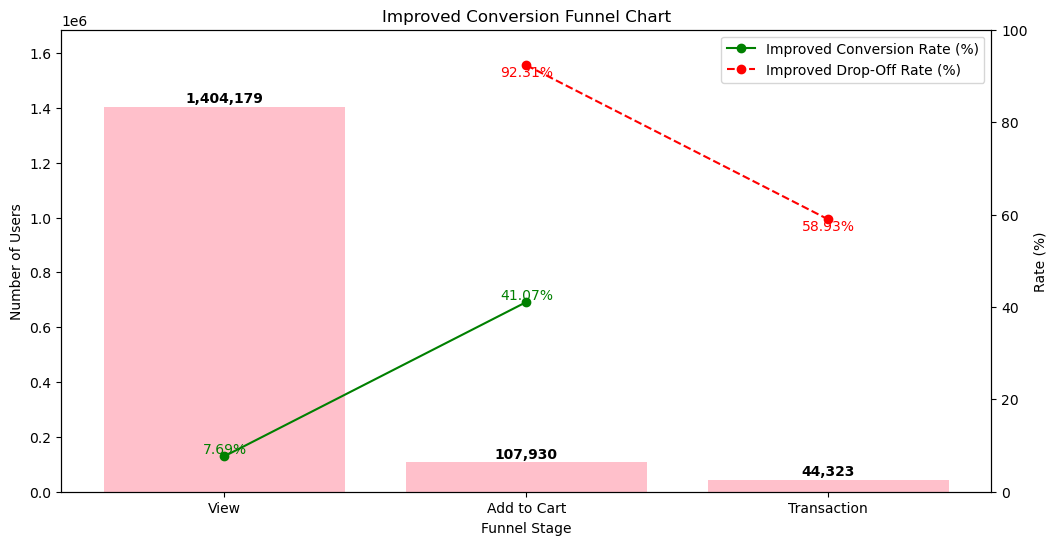

In [12]:
#Defining funnel stages and counts
stages = ['View', 'Add to Cart', 'Transaction']
current_counts = [funnel_counts['view'], funnel_counts['addtocart'], funnel_counts['transaction']]
current_conversion_rates = [current_counts[i] / current_counts[i-1] * 100 if i > 0 else 0 for i in range(len(current_counts))]
current_drop_off_rates = [100 - rate for rate in current_conversion_rates[1:]]

#Hypothetical improved conversion rates
improved_conversion_rates = [
    current_conversion_rates[1] + 5,  # View to Add to Cart
    current_conversion_rates[2] + 10  # Add to Cart to Transaction
]

#Calculating new funnel counts based on improved conversion rates
improved_counts = [
    current_counts[0],  # View remains the same
    int(current_counts[0] * improved_conversion_rates[0] / 100),
    int(current_counts[0] * improved_conversion_rates[0] / 100 * improved_conversion_rates[1] / 100)
]

#Calculating new drop-off rates
improved_drop_off_rates = [100 - rate for rate in improved_conversion_rates]

#Plotting improved funnel
fig, ax1 = plt.subplots(figsize=(12, 6))

#Plotting the funnel stages
bars = ax1.bar(stages, improved_counts, color='pink')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + max(improved_counts) * 0.01,
             f'{int(height):,}', ha='center', color='black', weight='bold')

#Creating a secondary y-axis for conversion rates
ax2 = ax1.twinx()
ax2.plot(stages[:-1], improved_conversion_rates, color='green', marker='o', linestyle='-', label='Improved Conversion Rate (%)', zorder=5)
ax2.plot(stages[1:], improved_drop_off_rates, color='red', marker='o', linestyle='--', label='Improved Drop-Off Rate (%)', zorder=5)

#Adding text annotations for rates
for i in range(len(improved_conversion_rates)):
    ax2.text(i, improved_conversion_rates[i], f'{improved_conversion_rates[i]:.2f}%', color='green', ha='center', va='bottom', zorder=10)
    ax2.text(i+1, improved_drop_off_rates[i], f'{improved_drop_off_rates[i]:.2f}%', color='red', ha='center', va='top', zorder=10)

#Adding title and labels
ax1.set_title('Improved Conversion Funnel Chart')
ax1.set_xlabel('Funnel Stage')
ax1.set_ylabel('Number of Users')
ax1.set_ylim(0, max(improved_counts) * 1.2)
ax2.set_ylim(0, 100)
ax2.set_ylabel('Rate (%)')
ax2.legend(loc='upper right')

plt.show()


### Insights and Analysis

#### Improved Funnel (After Hypothetical Improvement)
1. **View to Add to Cart**
   - Conversion Rate: 7.69% (Increased by 5%)
   - Drop-Off Rate: 92.31% (Decreased by 5%)
2. **Add to Cart to Transaction**
   - Conversion Rate: 41.07% (Increased by 10%)
   - Drop-Off Rate: 58.93% (Decreased by 10%)

### Potential Impact
1. **Increased Users at Each Stage**:
   - The number of users adding items to the cart has increased significantly from 37,722 to 107,930.
   - The number of users completing transactions has increased from 11,719 to 44,323.

2. **Overall Conversion Rate**:
   - The overall conversion rate has improved, indicating that more users are moving through the funnel and completing transactions.

### Conclusion
The improved conversion funnel chart effectively shows how hypothetical improvements could enhance user progression through the funnel. By implementing strategies to increase conversion rates at key stages, you can significantly reduce drop-off rates and improve overall conversions.

This simulation provides a compelling case for the potential impact of funnel optimization, even without the ability to run actual tests. It highlights the importance of targeted improvements and the positive outcomes they can achieve.